dogs vs cat

In [1]:
import zipfile, os, shutil, re
from os.path import isfile, isdir
import random
from tqdm import tqdm
import cv2
import numpy as np
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_input
from keras.applications.resnet50 import ResNet50,decode_predictions
from keras.applications.resnet50 import preprocess_input as resnet_input
from keras.applications.xception import Xception
# from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
# from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# extract train.zip image to folder 'train'
if not isdir('train'):
    zipFile = zipfile.ZipFile('train.zip')
    zipFile.extractall()
    zipFile.close()
    
# move cat's image to folder 'train/cat', dog's image to folder 'train/dog'
if not isdir('train/cat'):
    os.mkdir('train/cat')        # create folder train/cat
if not isdir('train/dog'):
    os.mkdir('train/dog')        # create folder train/dog
    
# search files in train folder, check whether it match cat or dog
for filename in os.listdir('train'):
    match_cat = re.search(r'cat.[0-9]*.jpg',filename)
    if match_cat:           # if filename including cat then move to folder train/cat
        shutil.move('train/'+filename, 'train/cat/')   
    
    match_dog = re.search(r'dog.[0-9]*.jpg',filename)
    if match_dog:           # if filename including dog then move to folder train/dog
        shutil.move('train/'+filename, 'train/dog/'+filename)
        
# extract test.zip image to folder 'test'
if not isdir('test'):
    zipFile = zipfile.ZipFile('test.zip')
    zipFile.extractall()
    zipFile.close()
    
if not isdir('test/test'):
    os.mkdir('test/test')        # if not exist test/test then create the sub-folder 'test/test'
    for filename in os.listdir('test'):      # search files in 'test', then move to sub-folder 'test/test'
        if not os.path.isdir(filename):      
            shutil.move('test/'+filename,'test/test/')

C:\Users\thomas_gui\AppData\Local\conda\conda\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


cat.0.jpg: dimension (374, 500, 3)
cat.1.jpg: dimension (280, 300, 3)
cat.2.jpg: dimension (396, 312, 3)
cat.3.jpg: dimension (414, 500, 3)
cat.4.jpg: dimension (375, 499, 3)
cat.5.jpg: dimension (144, 175, 3)
cat.6.jpg: dimension (303, 400, 3)
cat.7.jpg: dimension (499, 495, 3)
cat.8.jpg: dimension (345, 461, 3)
cat.9.jpg: dimension (425, 320, 3)


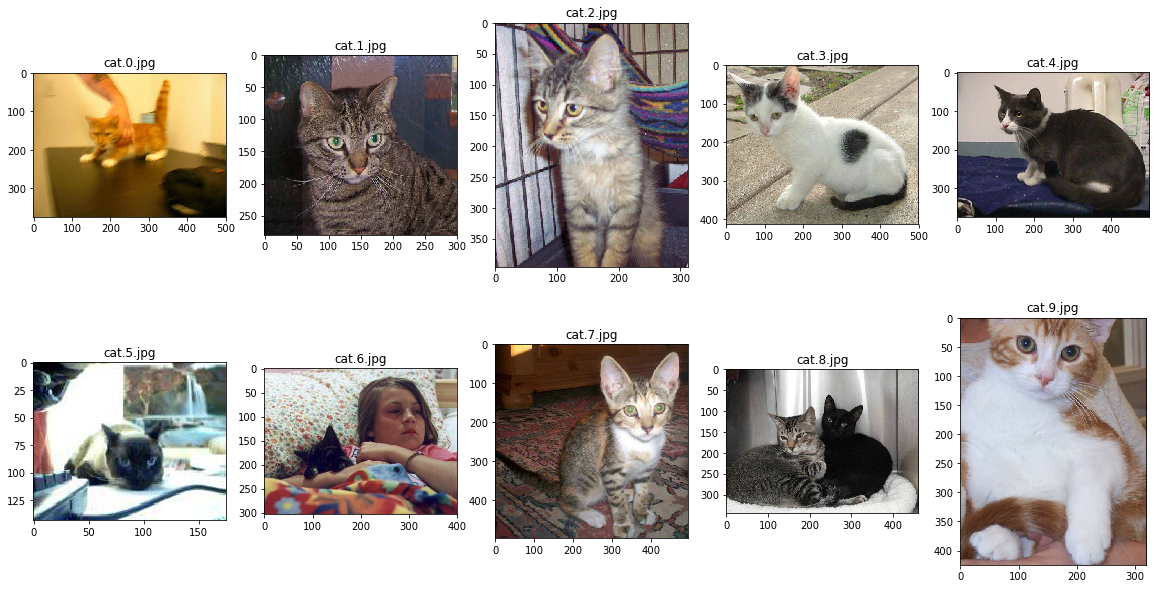

dog.0.jpg: dimension (375, 499, 3)
dog.1.jpg: dimension (499, 327, 3)
dog.2.jpg: dimension (199, 187, 3)
dog.3.jpg: dimension (375, 499, 3)
dog.4.jpg: dimension (287, 300, 3)
dog.5.jpg: dimension (376, 499, 3)
dog.6.jpg: dimension (488, 499, 3)
dog.7.jpg: dimension (264, 299, 3)
dog.8.jpg: dimension (500, 469, 3)
dog.9.jpg: dimension (500, 368, 3)


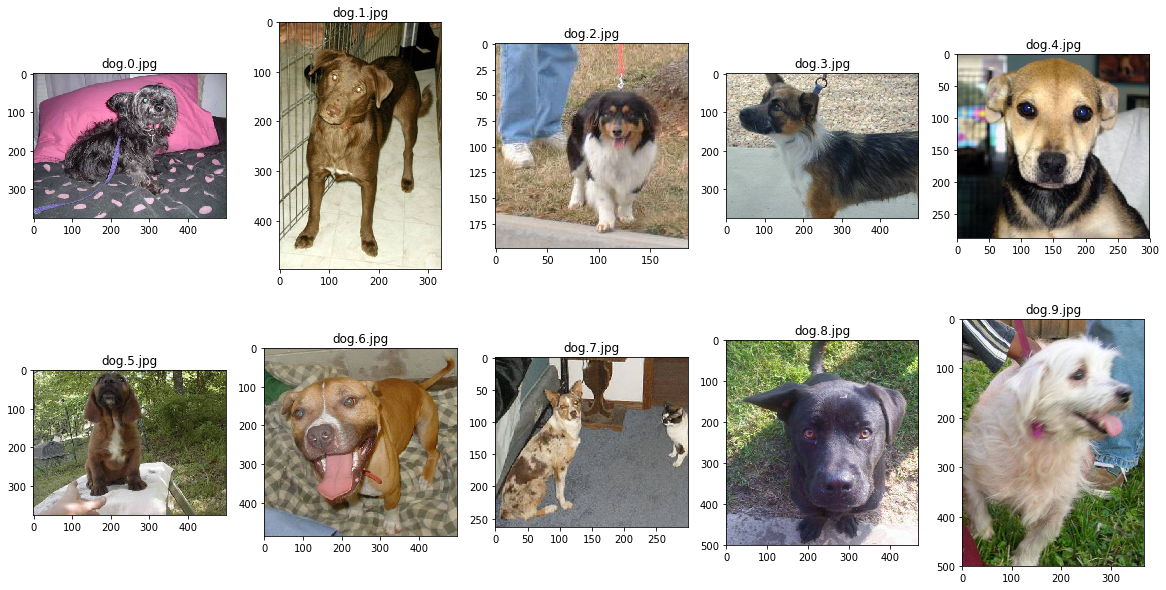

In [40]:
# Show cat picture of train
fig1 = plt.figure(figsize=(20,10))  # figure size=(20,10)
for i in range(10):
    img = mpimg.imread('train/cat/cat.%i.jpg'%i)
    print('cat.%i.jpg:'%i, 'dimension', img.shape)
    plt.subplot(2,5,i+1)
    plt.title('cat.%i.jpg'%i)
    plt.imshow(img)
plt.show()

# show dog picture of train
fig2 = plt.figure(figsize=(20,10))  # figure size=(20,10)
for i in range(10):
    img = mpimg.imread('train/dog/dog.%i.jpg'%i)
    print('dog.%i.jpg:'%i, 'dimension', img.shape)
    plt.subplot(2,5,i+1)
    plt.title('dog.%i.jpg'%i)
    plt.imshow(img)
plt.show()


1.jpg: dimension (499, 381, 3)
2.jpg: dimension (299, 296, 3)
3.jpg: dimension (299, 300, 3)
4.jpg: dimension (288, 374, 3)
5.jpg: dimension (400, 399, 3)
6.jpg: dimension (375, 499, 3)
7.jpg: dimension (148, 192, 3)
8.jpg: dimension (234, 325, 3)
9.jpg: dimension (380, 480, 3)
10.jpg: dimension (374, 500, 3)


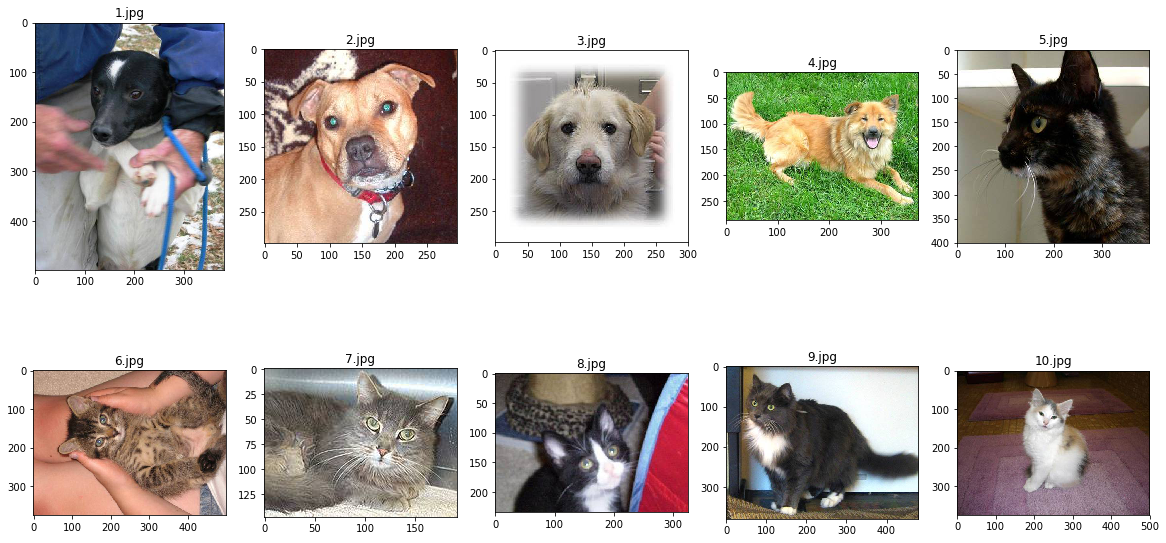

In [41]:
# show test picture
fig3 = plt.figure(figsize=(20,10))  # figure size=(20,10)
for i in range(10):
    i +=1
    img = mpimg.imread('test/test/%i.jpg'%i)
    print('%i.jpg:'%i, 'dimension', img.shape)
    plt.subplot(2,5,i)
    plt.title('%i.jpg'%i)
    plt.imshow(img)
plt.show()

In [2]:
# get cats & dogs dimension list
cats_dim = []
dogs_dim = []
for i in tqdm(range(12500)):
    img = mpimg.imread('train/cat/cat.%i.jpg'%i)
    cats_dim.append([img.shape[1],img.shape[0]])
    img = mpimg.imread('train/dog/dog.%i.jpg'%i)
    dogs_dim.append([img.shape[1],img.shape[0]]) 

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:49<00:00, 254.34it/s]


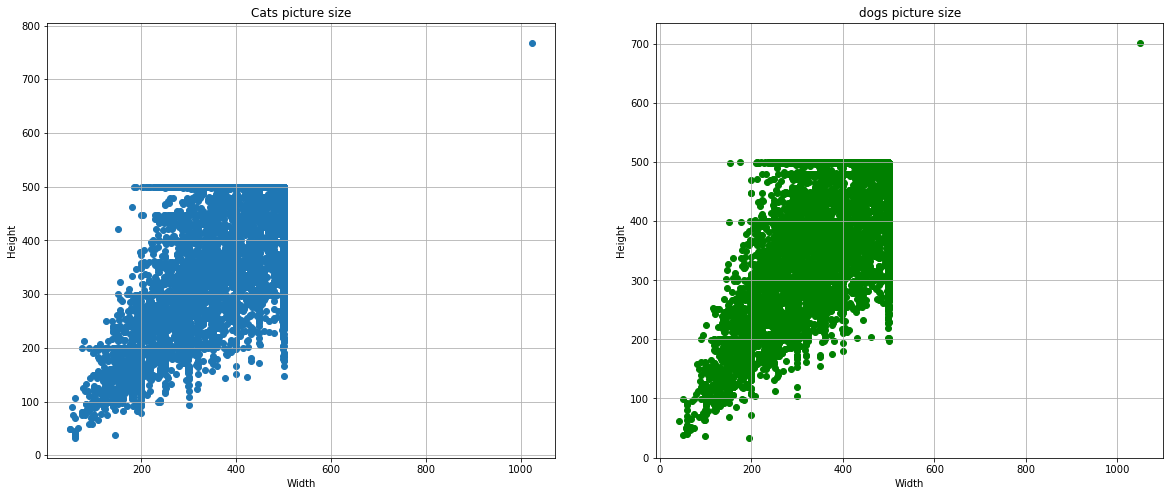

A large cat picture: train/cat/cat.835.jpg, size is: (1023, 768) 
A large dog picture: train/dog/dog.2317.jpg, size is: (1050, 702) 


In [6]:
# visualize train set cats & dogs size distribution
# convert cats & dogs dimension list to numpy array, easier to get dimension slice.
cats_dim = np.array(cats_dim)
dogs_dim = np.array(dogs_dim)

# set figure size
plt.figure(figsize=(20,8))

# subplot 1 of (1 x 2)
plt.subplot(121)
plt.grid()
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Cats picture size')
plt.scatter(cats_dim[:,0],cats_dim[:,1],marker = 'o')

# subplot 2 of (1 x 2)
plt.subplot(122)
plt.grid()
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('dogs picture size')
plt.scatter(dogs_dim[:,0],dogs_dim[:,1],marker = 'o',c = 'g')

plt.show()

# find a large size picture
for i in range(12500):
    if cats_dim[i][0] >= 1000:
        cat_path = 'train/cat/cat.%i.jpg'%i
        print('A large cat picture: {}, size is: {} '.format(cat_path, (cats_dim[i][0],cats_dim[i][1])))
    if dogs_dim[i][0] >= 1000:
        dog_path = 'train/dog/dog.%i.jpg'%i
        print('A large dog picture: {}, size is: {} '.format(dog_path, (dogs_dim[i][0],dogs_dim[i][1])))

In [35]:
# from imagenet, dogs class, cats class list
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

In [4]:
# generate batchs for ResNet50 predict_generator
def test_gen_224(X, batch_size): 
    
    datalen = len(X)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_224 = np.zeros((batch_size,224,224,3),dtype = np.float)
            for j in range(batch_size):
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
                
            X_224 = resnet_input(X_224)
            yield X_224

In [5]:
# use ResNet50 to predict picture class
# add non cat picture to cat_outlier list
# add non dog picture to dog_outlier list
# cat and dog train file list
X_catfile = ['train/cat/cat.%d.jpg' % i for i in range(12500)]
X_dogfile = ['train/dog/dog.%d.jpg' % i for i in range(12500)]

model = ResNet50(weights='imagenet')
cat_preds = model.predict_generator(test_gen_224(X_catfile,100),steps=125)
dog_preds = model.predict_generator(test_gen_224(X_dogfile,100),steps=125)

cat_outlier = []
dog_outlier = []
for i in tqdm(range(12500)):
    iscat = False
    isdog = False
    cat_prediction = decode_predictions(cat_preds[i:(i+1),:], top=30)[0]
    dog_prediction = decode_predictions(dog_preds[i:(i+1),:], top=30)[0] 
    for j in range(30):
        if cat_prediction[j][0] in cats:
            iscat = True
            break
    for j in range(30):        
        if dog_prediction[j][0] in dogs:
            isdog = True
            break
            
    if not iscat:
        cat_outlier.append(X_catfile[i])     # append cat picture outlier to list
    if not isdog:
        dog_outlier.append(X_dogfile[i])     # append cat picture outlier to list

# print('Number of outliers for cat: ',len(cat_outlier))
# print('Number of outliers for dog: ',len(dog_outlier))

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 6876.19it/s]


In [6]:
# use InceptionV3 to predict picture class
# choose non cat or non dog picture from previous list

cat_outlier1 = []
dog_outlier1 = []
model = InceptionV3(weights='imagenet')

for i in tqdm(range(len(cat_outlier))):
    img = image.load_img(cat_outlier[i], target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_input(x)
    cat_preds = model.predict(x)
    cat_prediction = decode_predictions(cat_preds, top=30)[0]
    
    iscat = False
    for j in range(30):
        if cat_prediction[j][0] in cats:
            iscat = True
            break
    if not iscat:
        cat_outlier1.append(cat_outlier[i])

for i in tqdm(range(len(dog_outlier))):
    img = image.load_img(dog_outlier[i], target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_input(x)
    dog_preds = model.predict(x)
    dog_prediction = decode_predictions(dog_preds, top=30)[0]
    
    isdog = False
    for j in range(30):
        if dog_prediction[j][0] in dogs:
            isdog = True
            break
    if not isdog:
        dog_outlier1.append(dog_outlier[i])
        
# print('Number of outliers for cat: ',len(cat_outlier1))
# print('Number of outliers for dog: ',len(dog_outlier1))

330
56


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.29it/s]


84
21


In [7]:
# use Xception to predict picture class
# choose non cat or non dog picture from previous list

cat_outlier = []
dog_outlier = []
model = Xception(weights='imagenet')

for i in tqdm(range(len(cat_outlier1))):
    img = image.load_img(cat_outlier1[i], target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_input(x)
    cat_preds = model.predict(x)
    cat_prediction = decode_predictions(cat_preds, top=30)[0]
    
    iscat = False
    for j in range(30):
        if cat_prediction[j][0] in cats:
            iscat = True
            break
    if not iscat:
        cat_outlier.append(cat_outlier1[i])

for i in tqdm(range(len(dog_outlier1))):
    img = image.load_img(dog_outlier1[i], target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_input(x)
    dog_preds = model.predict(x)
    dog_prediction = decode_predictions(dog_preds, top=30)[0]
    
    isdog = False
    for j in range(30):
        if dog_prediction[j][0] in dogs:
            isdog = True
            break
    if not isdog:
        dog_outlier.append(dog_outlier1[i])
        
# print('Number of outliers for cat: ',len(cat_outlier))
# print('Number of outliers for dog: ',len(dog_outlier))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 35.87it/s]


Number of outliers for cat:  46


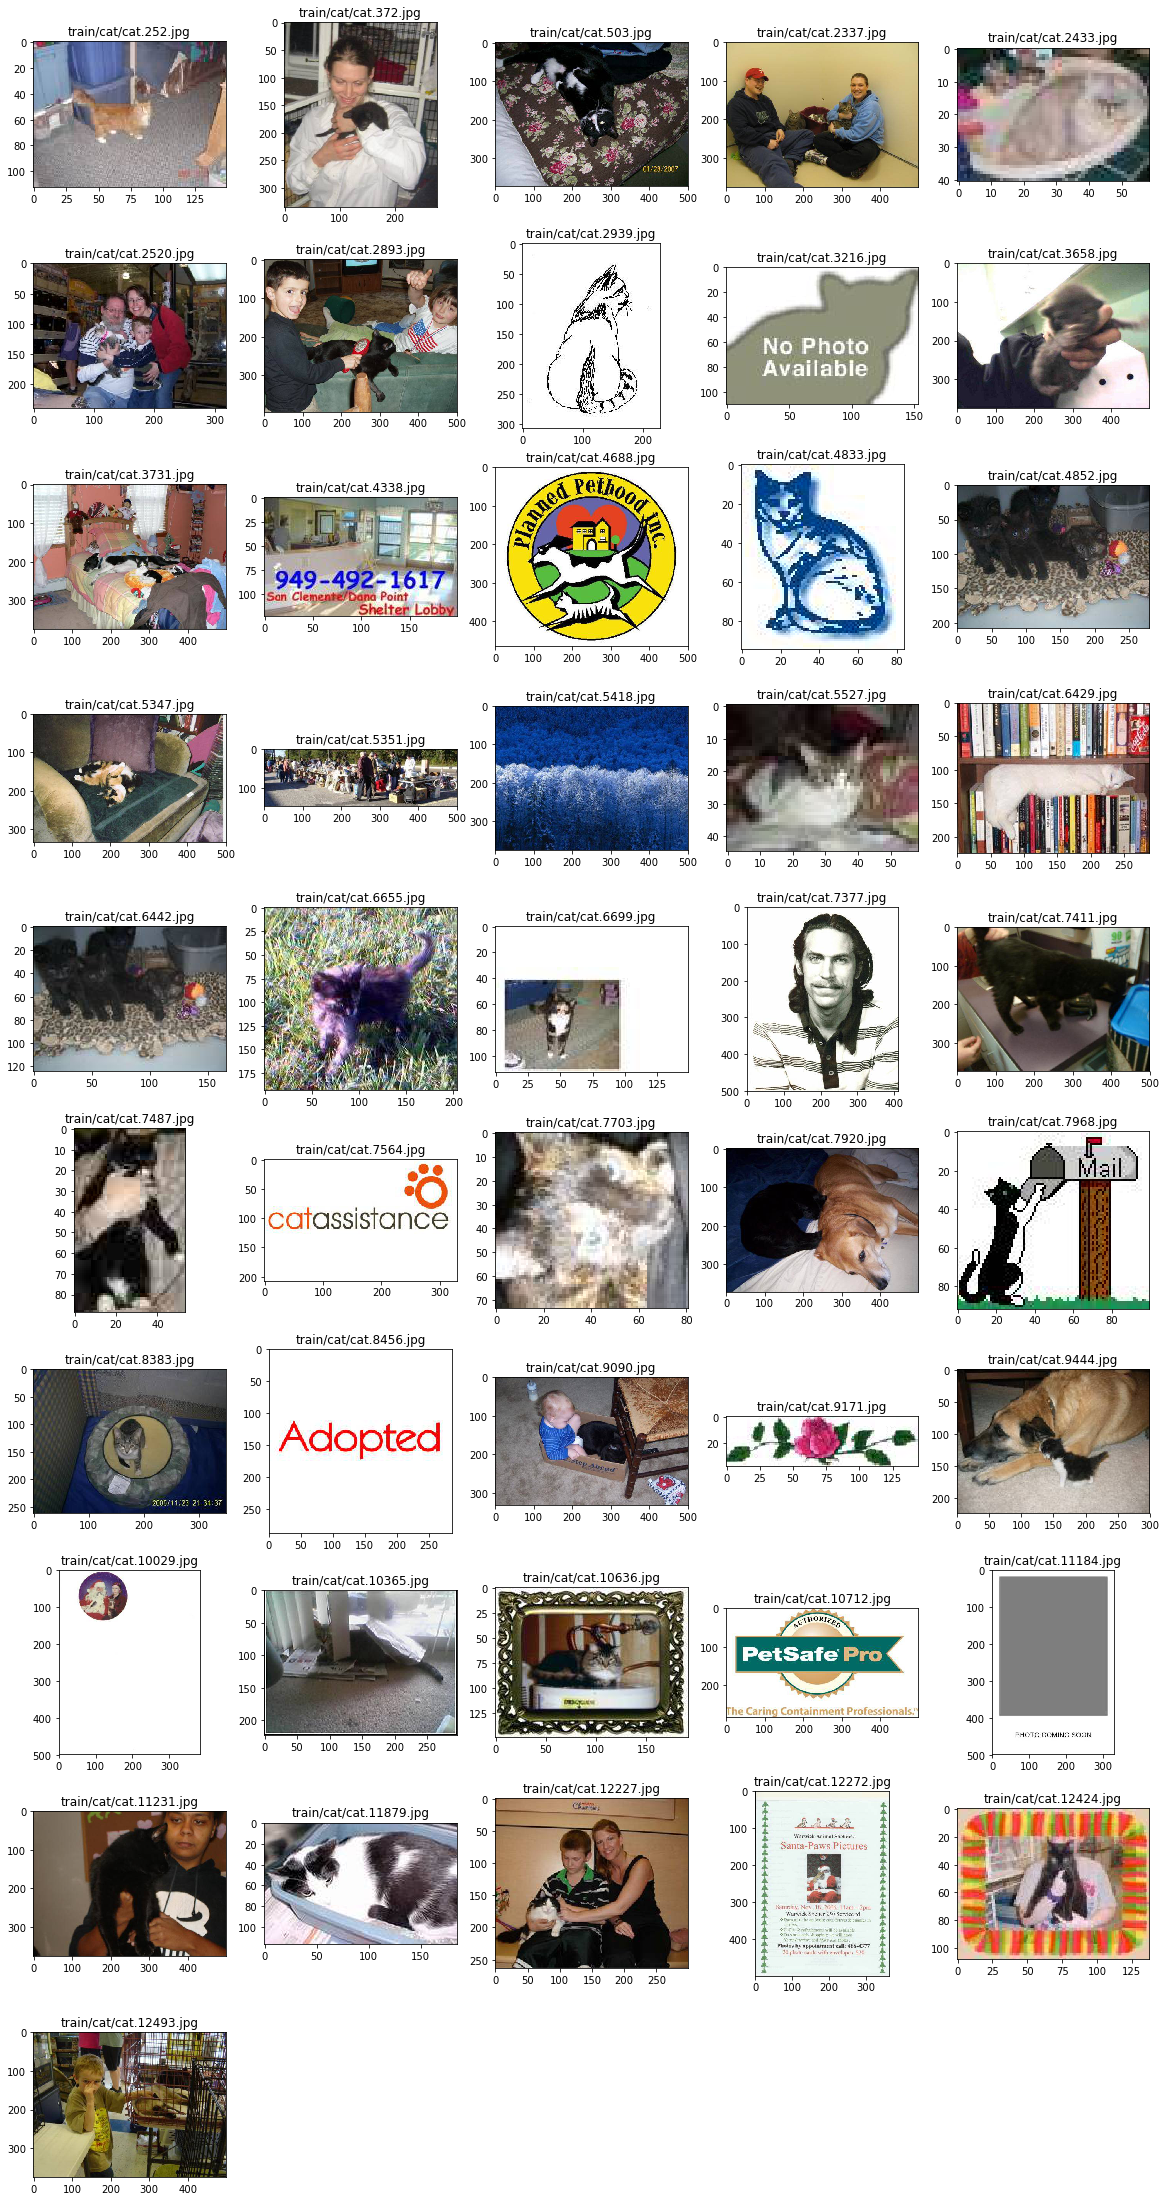

In [9]:
print('Number of outliers for cat: ',len(cat_outlier))

# print('non cat list:\n',cat_outlier)
fig1 = plt.figure(figsize=(20,40))  # figure size=(20,10)
for i in range(len(cat_outlier)):
    img = mpimg.imread(cat_outlier[i])
    plt.subplot(10,5,i+1)
    plt.title(cat_outlier[i])
    plt.imshow(img)
plt.show()



Number of outliers for cat:  18


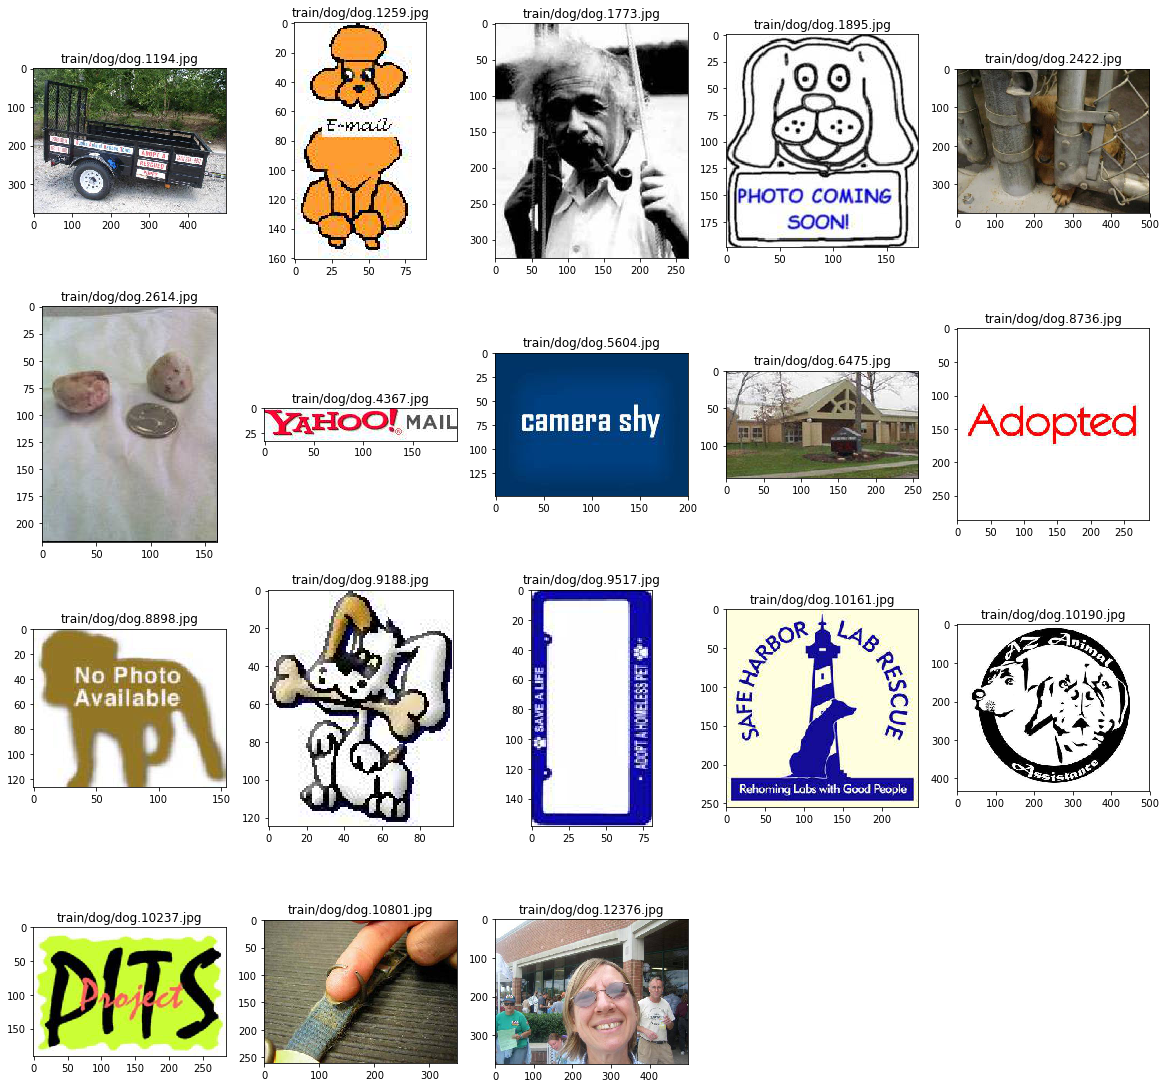

In [10]:
print('Number of outliers for dog: ',len(dog_outlier))

fig2 = plt.figure(figsize=(20,20))  # figure size=(20,10)
for i in range(len(dog_outlier)):
    img = mpimg.imread(dog_outlier[i])
    plt.subplot(4,5,i+1)
    plt.title(dog_outlier[i])
    plt.imshow(img)
plt.show()

In [2]:
# define random_transfer function
# used these functions for data argumentation

def random_crop(img, ratio=1.0):
    #随机剪裁, Ratio是裁剪后与裁剪前的面积比
    if random.random() < 1:
        h,w = img.shape[:2]
        #长宽比随机扰动变量 hw_delta
        hw_delta = np.random.uniform(-0.05,0.05)
        hw_mult = 1 + hw_delta
        
        w_crop = int(round(w*np.sqrt(ratio*hw_mult)))
        
        if w_crop > w:
            w_crop = w
        
        h_crop = int(round(h*np.sqrt(ratio/hw_mult)))
        if h_crop > h:
            h_crop = h
        
        x0 = np.random.randint(0,w-w_crop+1)
        y0 = np.random.randint(0,h-h_crop+1)
        
        img = img[y0:y0+h_crop,x0:x0+w_crop]
        
    return img
    
def random_rotate(img, angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        # angle = np.random.uniform(-angle,angle)
        # angle cycle is 360
        angle %= 360
        # 用openCV 内置函数计算仿射矩阵
        M_rotate = cv2.getRotationMatrix2D((w/2,h/2),angle,1)
        # 得到旋转后的图片
        img = cv2.warpAffine(img, M_rotate, (w, h))
        angle_crop = angle % 180
        
        if angle_crop > 90:
            angle_crop = 180 - angle_crop
        # convert to rad
        theta = angle_crop * np.pi / 180.0
        # compute high width ratio
        hw_ratio = float(h) / float(w)
        
        tan_theta = np.tan(theta)
        numerator = np.cos(theta) + np.sin(theta) * tan_theta
        
        # 计算分母项中的宽高比相关的项
        r = hw_ratio if h > w else 1/hw_ratio
        # 计算分母项
        denominator = r * tan_theta +1
        # 计算最终边长系数
        crop_mult = numerator / denominator
        # 得到剪裁区域
        w_crop = int(round(crop_mult*w))
        h_crop = int(round(crop_mult*h))
        x0 = int((w-w_crop)/2)
        y0 = int((h-h_crop)/2)
        img = img[y0:y0+h_crop,x0:x0+w_crop]
    return img

def random_shear(img,angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        #产生随机剪切角度值
        # angle = np.random.uniform(-angle,angle)
        # x轴剪切变换，角度值=angle
        theta = angle * np.pi / 180
        M_shear = np.array([[1,np.tan(theta), 0],[0,1,0]],dtype = np.float32)
        img = cv2.warpAffine(img, M_shear, (w, h))
    return img

def random_h_flip(img, horizontal_flip=False):
    if horizontal_flip == True:
        if random.random() < 1:
            img = cv2.flip(img, 1)
    return img
            
def random_v_flip(img, vertical_flip=False):
    if vertical_flip == True:
        if random.random() < 1:
            img = cv2.flip(img,0)
    return img    

def random_transfer(img, ratio=None,rotate=None,shear=None,
                  horizontal_flip=False,vertical_flip=False):
    params = {}
    if ratio is not None:
        params['ratio'] = ratio
    if rotate is not None:
        params['rotate'] = rotate
    if shear is not None:
        params['shear'] = shear
    if horizontal_flip:
        params['horizontal_flip'] = horizontal_flip
    if vertical_flip:
        params['vertical_flip'] = vertical_flip
        
    if params:
        func = []
        for param in params.keys():
            func.append(param)
    func = random.choice(func)
    # print(func,params[func])
    
    function_map = { 'ratio':random_crop,
                     'rotate':random_rotate,
                     'shear':random_shear,
                     'horizontal_flip':random_h_flip,
                     'vertical_flip':random_v_flip
                    }
    
    img_transfer = function_map[func](img,params[func])
    return img_transfer

In [18]:
# random choose a existing image, excute random transfer, replace each outlier image
for i in range(len(cat_outlier)):
    cat_file = random.choice(X_catfile)
    img_cat = cv2.imread(cat_file)
    img_cat = random_transfer(img_cat, 0.9,10,10,True,True)
    cv2.imwrite(cat_outlier[i],img_cat)
    
for i in range(len(dog_outlier)):
    dog_file = random.choice(X_dogfile)
    img_dog = cv2.imread(dog_file)
    img_dog = random_transfer(img_dog, 0.9,10,10,True,True)
    cv2.imwrite(dog_outlier[i],img_dog)

In [4]:
X_catfile = ['train/cat/cat.%d.jpg' % i for i in range(12500)]
X_dogfile = ['train/dog/dog.%d.jpg' % i for i in range(12500)]
# set the validation split = 0.2
# then split train_set into X_train,X_val, y_train, y_val
splitpoint = int(12500 * 0.8)
# to keep cat and dog file samples balance in train, validation set.
# split 10,000 cat file list into train, 2,500 cat file list into validation
X_catfile_train,X_catfile_val = X_catfile[:splitpoint],X_catfile[splitpoint:]
# split 10,000 dog file list into train, 2,500 dog file list into validation
X_dogfile_train,X_dogfile_val = X_dogfile[:splitpoint],X_dogfile[splitpoint:]
# merge cat and dog train set, total 20,000 file list, first 10,000 is cat file, next 10,000 is dog file
X_train = np.array(X_catfile_train + X_dogfile_train)
# generate train label, first 10,000 is cat file, label = 0 , then next 10,000 label = 1

y_train = np.array([0 for i in range(splitpoint)] + [1 for i in range(splitpoint)])
# same as above operation, merge cat cat and dog validation set, then generate validation label
X_val = np.array(X_catfile_val + X_dogfile_val)
y_val = np.array([0 for i in range(splitpoint,12500)] + [1 for i in range(splitpoint,12500)])

# shuffle train & validation set
# set index for train and validation set
train_idx = np.arange(20000)
val_idx = np.arange(5000)
# set random seed to make sure shuffle result not change everytime
random.seed(2018)
# shuffle train index
random.shuffle(train_idx)

random.seed(2018)
# shuffle validation index
random.shuffle(val_idx)
# re-arrange X_train,y_train by shuffled index
X_train,y_train = X_train[train_idx],y_train[train_idx]
X_val,y_val = X_val[val_idx],y_val[val_idx]
#print(y_train.sum())    #half sample list is cat，another one is dog, so train label sum = 10,000

In [5]:
batch_size = 50
epochs = 10

# define train_generator function, yield batchs of train and validation data 
def train_generator(X, y, batch_size): 
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_299 = np.zeros((batch_size,299,299,3),dtype = np.float)
            for j in range(batch_size):
                X_299[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(299,299))
                
            X_299 = inception_input(X_299)
            yield X_299, y[i * batch_size:(i + 1) * batch_size]

def val_generator(X, y, batch_size):
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_299 = np.zeros((batch_size,299,299,3),dtype = np.float)
            for j in range(batch_size):
                X_299[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(299,299))
                
            X_299 = inception_input(X_299)
            yield X_299, y[i * batch_size:(i + 1) * batch_size]

In [10]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model

model_InceptionV3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape=(299,299,3))
for layer in model_InceptionV3.layers:
    layer.trainable = False
model = GlobalAveragePooling2D() (model_InceptionV3.output)

model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)
model_InceptionV3 = Model(model_InceptionV3.input,model, name = 'model_InceptionV3')

# plot_model(model_InceptionV3_GAP, to_file='model_InceptionV3.png',show_shapes = True) 
# SVG(model_to_dot(model_InceptionV3).create(prog='dot', format='svg'))

model_InceptionV3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 35, 35, 64)   192         conv2d_208[0][0]                 
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 35, 35, 64)   192         conv2d_210[0][0]                 
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 35, 35, 96)   288         conv2d_213[0][0]                 
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 35, 35, 64)   192         conv2d_214[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 35, 35, 64)   0           batch_normalization_208[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 17, 17, 192)  576         conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_232 (BatchN (None, 17, 17, 192)  576         conv2d_232[0][0]                 
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 17, 17, 192)  576         conv2d_237[0][0]                 
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 17, 17, 192)  576         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 17, 17, 192)  0           batch_normalization_229[0][0]    
__________

batch_normalization_262 (BatchN (None, 17, 17, 192)  576         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_262 (Activation)     (None, 17, 17, 192)  0           batch_normalization_262[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 17, 17, 192)  258048      activation_262[0][0]             
__________________________________________________________________________________________________
batch_normalization_259 (BatchN (None, 17, 17, 192)  576         conv2d_259[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_6[0][0]              
                                                                 activation_282[0][0]             
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           global_average_pooling2d_3[0][0] 
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            2049        dropout_3[0][0]                  
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
___________________________

In [11]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_InceptionV3.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_InceptionV3_history = model_InceptionV3.fit_generator(train_generator(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_generator(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)


Epoch 1/10
 - 240s - loss: 0.2065 - acc: 0.9227 - val_loss: 0.0825 - val_acc: 0.9724
Epoch 2/10
 - 240s - loss: 0.1164 - acc: 0.9567 - val_loss: 0.0743 - val_acc: 0.9754
Epoch 3/10
 - 240s - loss: 0.1058 - acc: 0.9597 - val_loss: 0.0787 - val_acc: 0.9742
Epoch 4/10
 - 240s - loss: 0.1031 - acc: 0.9617 - val_loss: 0.0782 - val_acc: 0.9760
Epoch 5/10
 - 240s - loss: 0.0967 - acc: 0.9637 - val_loss: 0.0736 - val_acc: 0.9778
Epoch 6/10
 - 240s - loss: 0.0939 - acc: 0.9636 - val_loss: 0.0654 - val_acc: 0.9810
Epoch 7/10
 - 240s - loss: 0.0945 - acc: 0.9646 - val_loss: 0.0840 - val_acc: 0.9744
Epoch 8/10
 - 240s - loss: 0.0938 - acc: 0.9648 - val_loss: 0.0822 - val_acc: 0.9756
Epoch 9/10
 - 240s - loss: 0.0914 - acc: 0.9663 - val_loss: 0.0721 - val_acc: 0.9788
Epoch 10/10
 - 240s - loss: 0.0912 - acc: 0.9648 - val_loss: 0.0848 - val_acc: 0.9752


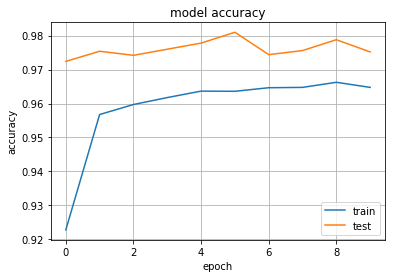

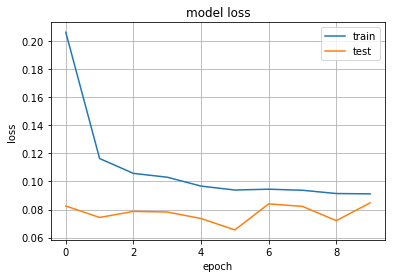

In [35]:
from matplotlib import pyplot as plt  
history=model_InceptionV3_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [14]:
# define train_generator function, yield batchs of train and validation data 
def train_gen_224(X, y, batch_size): 
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_224 = np.zeros((batch_size,224,224,3),dtype = np.float)
            for j in range(batch_size):
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
                
            X_224 = resnet_input(X_224)
            yield X_224, y[i * batch_size:(i + 1) * batch_size]

def val_gen_224(X, y, batch_size):
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_224 = np.zeros((batch_size,224,224,3),dtype = np.float)
            for j in range(batch_size):
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
                
            X_224 = resnet_input(X_224)
            yield X_224, y[i * batch_size:(i + 1) * batch_size]

In [15]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3),pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
x = Dropout(0.5)(base_model.output)
x = Dense(1, activation='sigmoid')(x)
model_ResNet50 = Model(inputs = base_model.input, outputs=x, name = 'model_ResNet50')
model_ResNet50.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_301[0][0]             
__________________________________________________________________________________________________
activation_304 (Activation)     (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_304[0][0]             
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_326 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_326[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_327 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_327[0][0]             
__________

In [16]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_ResNet50.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_ResNet50_history = model_ResNet50.fit_generator(train_gen_224(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_gen_224(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)

Epoch 1/10
 - 179s - loss: 0.1637 - acc: 0.9333 - val_loss: 0.0772 - val_acc: 0.9714
Epoch 2/10
 - 177s - loss: 0.0959 - acc: 0.9627 - val_loss: 0.0837 - val_acc: 0.9708
Epoch 3/10
 - 176s - loss: 0.0843 - acc: 0.9667 - val_loss: 0.0884 - val_acc: 0.9706
Epoch 4/10
 - 176s - loss: 0.0853 - acc: 0.9667 - val_loss: 0.0775 - val_acc: 0.9738
Epoch 5/10
 - 176s - loss: 0.0786 - acc: 0.9691 - val_loss: 0.0771 - val_acc: 0.9740
Epoch 6/10
 - 176s - loss: 0.0796 - acc: 0.9691 - val_loss: 0.0849 - val_acc: 0.9728
Epoch 7/10
 - 178s - loss: 0.0779 - acc: 0.9697 - val_loss: 0.0890 - val_acc: 0.9716
Epoch 8/10
 - 178s - loss: 0.0783 - acc: 0.9695 - val_loss: 0.1010 - val_acc: 0.9698
Epoch 9/10
 - 177s - loss: 0.0744 - acc: 0.9723 - val_loss: 0.0823 - val_acc: 0.9738
Epoch 10/10
 - 176s - loss: 0.0737 - acc: 0.9718 - val_loss: 0.0997 - val_acc: 0.9706


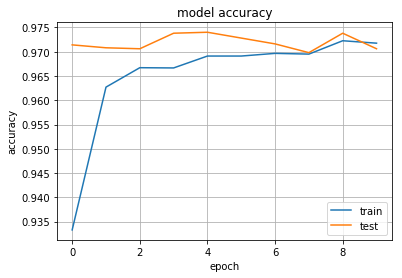

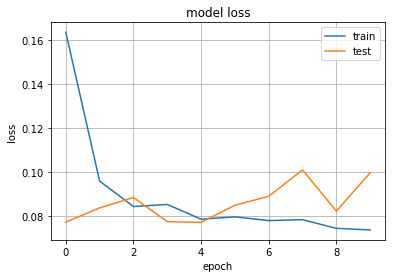

In [17]:
from matplotlib import pyplot as plt  
history=model_ResNet50_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [18]:

base_model = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3),pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
x = Dropout(0.5)(base_model.output)
x = Dense(1, activation='sigmoid')(x)
model_Xception = Model(inputs = base_model.input, outputs=x, name = 'model_Xception')
model_Xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 19, 19, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

In [19]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_Xception.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_Xception_history = model_Xception.fit_generator(train_generator(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_generator(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)

Epoch 1/10
 - 367s - loss: 0.1356 - acc: 0.9645 - val_loss: 0.0901 - val_acc: 0.9768
Epoch 2/10
 - 364s - loss: 0.0630 - acc: 0.9799 - val_loss: 0.0783 - val_acc: 0.9776
Epoch 3/10
 - 364s - loss: 0.0546 - acc: 0.9820 - val_loss: 0.0801 - val_acc: 0.9764
Epoch 4/10
 - 364s - loss: 0.0487 - acc: 0.9829 - val_loss: 0.0758 - val_acc: 0.9774
Epoch 5/10
 - 364s - loss: 0.0490 - acc: 0.9825 - val_loss: 0.0791 - val_acc: 0.9756
Epoch 6/10
 - 364s - loss: 0.0472 - acc: 0.9834 - val_loss: 0.0722 - val_acc: 0.9780
Epoch 7/10
 - 363s - loss: 0.0447 - acc: 0.9843 - val_loss: 0.0696 - val_acc: 0.9798
Epoch 8/10
 - 364s - loss: 0.0438 - acc: 0.9839 - val_loss: 0.0754 - val_acc: 0.9772
Epoch 9/10
 - 364s - loss: 0.0444 - acc: 0.9840 - val_loss: 0.0729 - val_acc: 0.9784
Epoch 10/10
 - 363s - loss: 0.0424 - acc: 0.9848 - val_loss: 0.0734 - val_acc: 0.9780


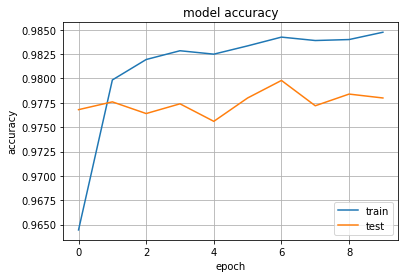

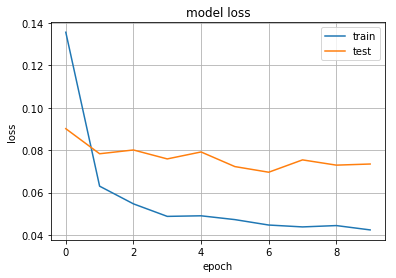

In [20]:
from matplotlib import pyplot as plt  
history=model_Xception_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [ ]:
# test generator
n_test = 12500
X_test = np.zeros((n_test,299,299,3),dtype=np.uint8)
for i in tqdm(range(12500)):
    j = i+1
    X_test[i] = cv2.resize(cv2.imread('test/test/%d.jpg' % j), (299,299))
    
def test_generator(X, batch_size): 
    datalen = len(X)
    counter = datalen//batch_size
    while (True):
        for i in range(counter):
            yield (X[i * batch_size:(i + 1) * batch_size]-127.5)/127.5


In [ ]:
# make prediction
# clip log-loss results to range(0.005,0.995)
predictions = model_InceptionV3_GAP.predict_generator(test_generator(X_test,100),steps=125, verbose=1)
predictions = predictions.clip(min=0.005,max=0.995)
output = pd.read_csv('sample_submission.csv')
print(len(predictions))
output.label = predictions
output.to_csv('InceptionV3_predictions.csv',index=None)